In [1]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
# Inicialización de librerías
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# La data se encuentra en kaggle por el tamaño de los datos no puede cargarse en github.

In [160]:
df_train = pd.read_csv('../datasets/input/fraudTrain.csv')
df_test = pd.read_csv('../datasets/input/fraudTest.csv')
df_alldata = pd.concat([df_train, df_test])

In [161]:
data = df_alldata[['trans_date_trans_time', 'is_fraud']]

In [162]:
del df_alldata

In [163]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

In [164]:
data.set_index('trans_date_trans_time', inplace=True)
data

,is_fraud
trans_date_trans_time,
2019-01-01 00:00:18,0
2019-01-01 00:00:44,0
2019-01-01 00:00:51,0
2019-01-01 00:01:16,0
2019-01-01 00:03:06,0
...,...
2020-12-31 23:59:07,0
2020-12-31 23:59:09,0
2020-12-31 23:59:15,0


In [165]:
data.index.is_monotonic_increasing

False

In [166]:
# Ordenar el indice
data.sort_index(inplace=True)

In [167]:
data.index.is_monotonic_increasing

True

In [168]:
# Ver las fechas de inicio y fin 
print('Fecha inicial:',data.index.min())
print('Fecha final:', data.index.max())

Fecha inicial: 2019-01-01 00:00:18
Fecha final: 2020-12-31 23:59:34


## Remuestreo por hora

In [169]:
# Remuestreo por hora 
data = data.resample('1H').sum()

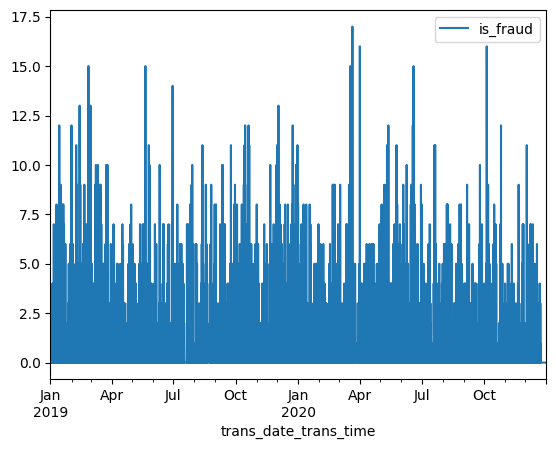

In [170]:
# Visualizar los datos
data.plot()
plt.show()

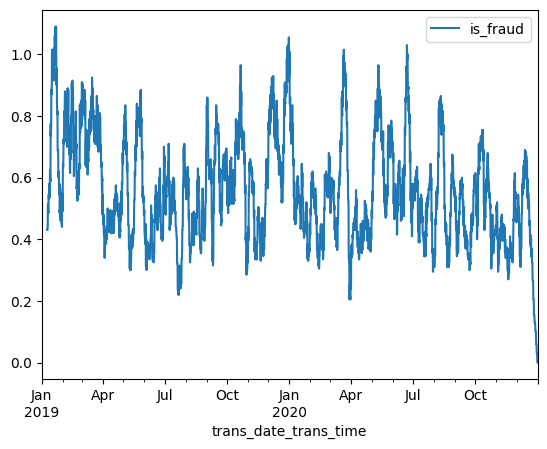

In [171]:
# Visualizar la media móvil 
data.rolling(200).mean().plot()
plt.show()

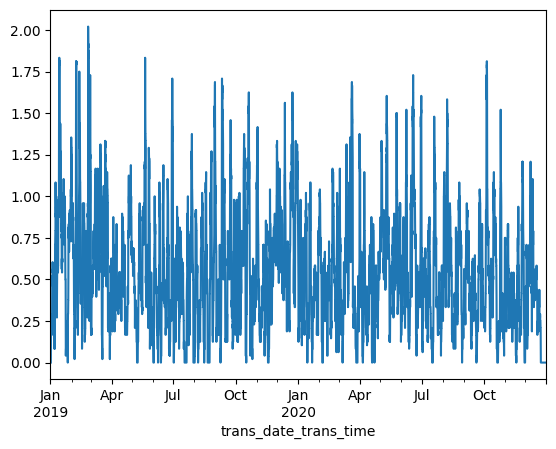

In [172]:
# Descomponer los datos
decomposed = seasonal_decompose(data)

# Visualizar la tendencia
decomposed.trend.plot()
plt.show()

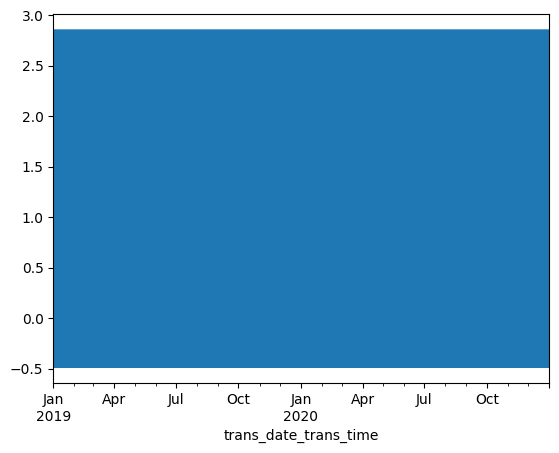

In [173]:
# Visualiar seasonal
decomposed.seasonal.plot()
plt.show()

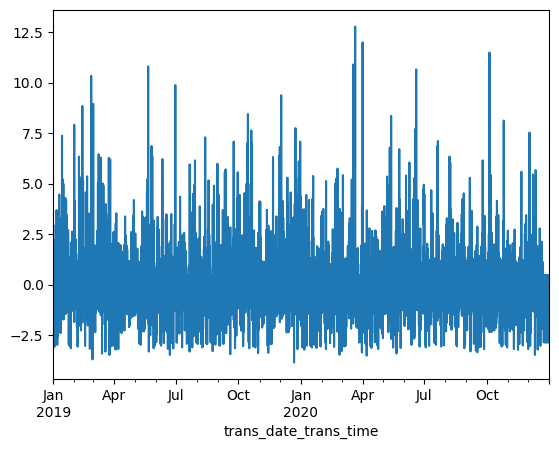

In [174]:
# Visualiar el residuo
decomposed.resid.plot()
plt.show()

## Feature engineering

In [153]:
def make_features(data, max_lag):

    '''
    Crea nuevas características a partir de un dataframe con index del tipo datetime.
    Crea las columnas year, month, day y day of week. Agrega n características de desfase
    de acuerdo a la variable max_lag. Agrega una columna de tendencia y otra estacional.
    in: dataframe con index datetime.
    out: dataframe con las características agregadas.
    '''
    df = data.copy()
    # Separar el año, día, mes y día de la semana en columnas diferentes
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek   

    # Características de desfase
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['is_fraud'].shift(lag)

    # Característica de tendencia
    df['trending'] = seasonal_decompose(df['is_fraud']).trend.shift()

    # Caracteristica estacional
    df['seasonal'] = seasonal_decompose(df['is_fraud']).seasonal.shift()
    return df

In [213]:
# Agregar las nuevas carcterísticas al dataframe
# 60 Desfases
new_data = make_features(data, 70)
# Visualizar el dataframe creado
new_data

,is_fraud,year,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,trending,seasonal
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0,2019,1,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,0,2019,1,1,1,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.576541
2019-01-01 02:00:00,0,2019,1,1,1,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.582021
2019-01-01 03:00:00,0,2019,1,1,1,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535445
2019-01-01 04:00:00,0,2019,1,1,1,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.549144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0,2020,12,31,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.398801
2020-12-31 20:00:00,0,2020,12,31,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.407021
2020-12-31 21:00:00,0,2020,12,31,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.416610


## Dividir en entrenamiento y prueba

In [214]:
# Dividir el dataframe en entrenamiento y prueba 
train, test = train_test_split(new_data, test_size=0.1, shuffle=False)

# Eliminar las filas con valores ausentes
train.dropna(inplace=True) 
test.dropna(inplace=True)

# Dividir las características y el objetivo
features_train = train.drop(['is_fraud'], axis=1)
target_train = train['is_fraud']
features_test = test.drop(['is_fraud'], axis = 1)
target_test = test['is_fraud']

## Regresión lineal

In [215]:
# Entrenar el modelo de regresión lineal (prueba de cordura)
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(target_train, pred_train) ** 0.5) 
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test) ** 0.5) 

RECM para el conjunto de entrenamiento: 0.997994791300227
RECM para el conjunto de prueba: 0.7980564371853399


.90 con 10
.86 con 20
.8122 con 30
.8118 con 40
.7997 con 50
.7983 con 60
.7980 con 70

## Bosque aleatorio

In [216]:
# Entrenar un modelo de bosque aleatorio básico
model = RandomForestRegressor(random_state=54321)

# Hiperparámetros a buscar
param_grid = {
    'max_depth': [20],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'n_estimators': [150]
}

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=5), n_jobs=-1
)

# Ajuste del conjunto de entrenamiento
grid_search.fit(features_train, target_train)

# Imprimir los mejores hiperparámetros
print(f'Mejores hiperprámetros: {grid_search.best_params_}')

# Predicción del conjunto de prueba
predicts = grid_search.predict(features_test)

# Calcular la raíz del error cuadrático medio
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, predicts) ** 0.5) 

Mejores hiperprámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150}
RECM para el conjunto de prueba: 0.6481087322456539


10 = 0.65
20 = 0.6533
70= 0.64

## Catboost

In [218]:
# Definir el modelo
model_catboost = CatBoostRegressor(task_type='GPU', random_state=42)

# Establecer los hiperparámetros a buscar
param_grid = { 
    'depth': [8],
    'iterations': [1500],
    'l2_leaf_reg': [1],
    'learning_rate': [.05],
    'grow_policy': ['SymmetricTree'],
    'random_strength': [1],
    #'subsample': [0.8],
}

# Configuración de la división temporal para validación
tscv = TimeSeriesSplit(n_splits=5)

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    model_catboost, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1
)

# Ajuste del modelo con el conjunto de entrenamiento
grid_search.fit(features_train, target_train)

# Obtener de los mejores hiperparámetros
best_params = grid_search.best_params_
print(f'Mejores hiperparámetros: {best_params}')

# Obtener el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Predicciones del conjunto del prueba
pred_test = grid_search.predict(features_test)

# Calcular la raíz del error cuadrático medio
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test) ** 0.5) 

## 60 lag: 
1499:	learn: 0.3250588	total: 8.89s	remaining: 0us
Mejores hiperparámetros: {'depth': 8, 'grow_policy': 'SymmetricTree', 'iterations': 1500, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'random_strength': 1, 'rsm': None}
RECM para el conjunto de prueba: 0.616049134859515

In [ ]:
60

In [16]:
data.set_index('trans_date_trans_time', inplace=True)

In [12]:
data.head()

,is_fraud
trans_date_trans_time,
2019-01-01 00:00:18,0
2019-01-01 00:00:44,0
2019-01-01 00:00:51,0
2019-01-01 00:01:16,0
2019-01-01 00:03:06,0


In [ ]:
df_fraudes_diarios = data.resample('1H').sum()

In [7]:
data.describe()

,trans_date_trans_time,is_fraud
count,1852394,1.852394e+06
mean,2020-01-20 21:31:46.801827328,5.210015e-03
min,2019-01-01 00:00:18,0.000000e+00
25%,2019-07-23 04:13:43.750000128,0.000000e+00
50%,2020-01-02 01:15:31,0.000000e+00
75%,2020-07-23 12:11:25.249999872,0.000000e+00
max,2020-12-31 23:59:34,1.000000e+00
std,NaN,7.199217e-02


In [7]:
df_fraudes_diarios = df_fraudes.resample('D', on='trans_date_trans_time').size().reset_index(name='total_fraudes')

In [8]:
df_fraudes_diarios.set_index('trans_date_trans_time', inplace=True)

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_fraudes_diarios['total_fraudes'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.487070943760043
p-value: 2.21765751021138e-06


Nota: 
Serie es estacionaria al ser p_value menor a 0.05

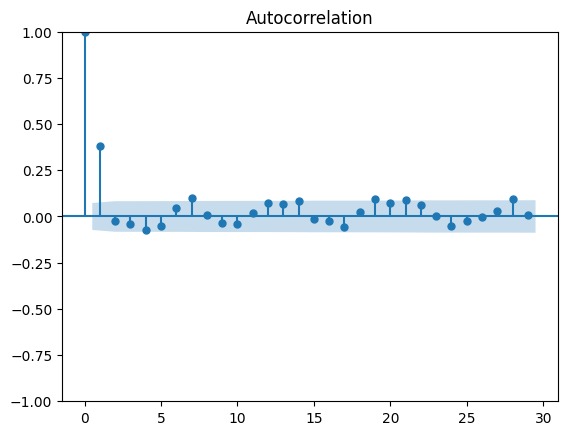

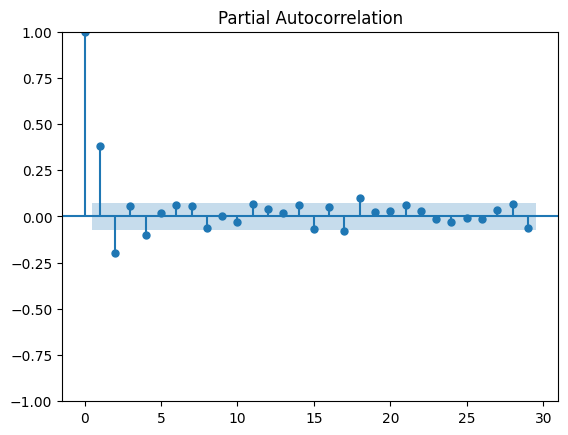

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Gráfico de ACF
plot_acf(df_fraudes_diarios['total_fraudes'])
plt.show()

# Gráfico de PACF
plot_pacf(df_fraudes_diarios['total_fraudes'])
plt.show()

In [20]:
# Definir el modelo ARIMA con parámetros (p, d, q)
model = ARIMA(df_fraudes_diarios[:-60], order=(40, 0, 80))  # Puedes ajustar los parámetros según sea necesario
model_fit = model.fit()

# Predecir los próximos 60 días (2 meses)
forecast = model_fit.forecast(steps=60)

# Visualizar los resultados
plt.figure(figsize=(10,6))
plt.plot(df_fraudes_diarios, label='Datos Históricos')
plt.plot(forecast.index, forecast, label='Predicción para 2 meses')
plt.legend()
plt.show()

c:\Users\esteb\OneDrive\Escritorio\No country\c20-70-n-data-bi\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\esteb\OneDrive\Escritorio\No country\c20-70-n-data-bi\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\esteb\OneDrive\Escritorio\No country\c20-70-n-data-bi\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\esteb\OneDrive\Escritorio\No country\c20-70-n-data-bi\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starti

KeyboardInterrupt: 

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_true = df_fraudes_diarios[-60:]  # Comparar con los últimos 60 días reales si están disponibles
mse = mean_squared_error(y_true, forecast)
mae = mean_absolute_error(y_true, forecast)
rmse = np.sqrt(mse)

print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

MSE: 66.272935717541, MAE: 6.7998016163750865, RMSE: 8.140819106056897


ARIMA = 10, 0, 60
MSE: 68.82787156387485, MAE: 7.019428452747477, RMSE: 8.296256478911127

ARIMA = 40, 0, 60
MSE: 68.82787156387485, MAE: 7.019428452747477, RMSE: 8.296256478911127